# Problem Statement : predicting turbine energy yield (TEY) using ambient variables as features.
Variable (Abbr.)  
Ambient temperature (AT)  
Ambient pressure (AP)  
Ambient humidity (AH)  
Air filter difference pressure (AFDP) mbar   
Gas turbine exhaust pressure (GTEP) mbar  
Turbine inlet temperature (TIT) C   
Turbine after temperature (TAT) C  
Compressor discharge pressure (CDP)  
Turbine energy yield (TEY) MWH  
Carbon monoxide (CO) mg/m3  
Nitrogen oxides (NOx) mg/m3  

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
data = pd.read_csv("gas_turbines.csv")
data.head()

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  114.70  10.605   
1  6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  114.72  10.598   
2  6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  114.71  10.601   
3  7.0569  1009.2  95.249  3.4805  19.792  1059.6  549.99  114.72  10.606   
4  7.3978  1009.7  95.150  3.4976  19.765  1059.7  549.98  114.72  10.612   

       CO     NOX  
0  3.1547  82.722  
1  3.2363  82.776  
2  3.2012  82.468  
3  3.1923  82.670  
4  3.2484  82.311

In [3]:
data.columns = ["temp","pressure","humidity","diff_press","exhaust_press","inlet_temp","after_temp",
               "yield","discharge_press","CO","NO"]
data.head()

temp  pressure  humidity  diff_press  exhaust_press  inlet_temp  \
0  6.8594    1007.9    96.799      3.5000         19.663      1059.2   
1  6.7850    1008.4    97.118      3.4998         19.728      1059.3   
2  6.8977    1008.8    95.939      3.4824         19.779      1059.4   
3  7.0569    1009.2    95.249      3.4805         19.792      1059.6   
4  7.3978    1009.7    95.150      3.4976         19.765      1059.7   

   after_temp   yield  discharge_press      CO      NO  
0      550.00  114.70           10.605  3.1547  82.722  
1      550.00  114.72           10.598  3.2363  82.776  
2      549.87  114.71           10.601  3.2012  82.468  
3      549.99  114.72           10.606  3.1923  82.670  
4      549.98  114.72           10.612  3.2484  82.311

# EDA and data preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temp             15039 non-null  float64
 1   pressure         15039 non-null  float64
 2   humidity         15039 non-null  float64
 3   diff_press       15039 non-null  float64
 4   exhaust_press    15039 non-null  float64
 5   inlet_temp       15039 non-null  float64
 6   after_temp       15039 non-null  float64
 7   yield            15039 non-null  float64
 8   discharge_press  15039 non-null  float64
 9   CO               15039 non-null  float64
 10  NO               15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


**no null value**

In [5]:
data.describe().T

count         mean        std          min          25%  \
temp             15039.0    17.764381   7.574323     0.522300    11.408000   
pressure         15039.0  1013.199240   6.410760   985.850000  1008.900000   
humidity         15039.0    79.124174  13.793439    30.344000    69.750000   
diff_press       15039.0     4.200294   0.760197     2.087400     3.723900   
exhaust_press    15039.0    25.419061   4.173916    17.878000    23.294000   
inlet_temp       15039.0  1083.798770  16.527806  1000.800000  1079.600000   
after_temp       15039.0   545.396183   7.866803   512.450000   542.170000   
yield            15039.0   134.188464  15.829717   100.170000   127.985000   
discharge_press  15039.0    12.102353   1.103196     9.904400    11.622000   
CO               15039.0     1.972499   2.222206     0.000388     0.858055   
NO               15039.0    68.190934  10.470586    27.765000    61.303500   

                       50%        75%        max  
temp               18.1860    23.8625    34.9290  
pressure         1012.8000  1016.9000  1034.2000  
humidity           82.2660    90.0435   100.2000  
diff_press          4.1862     4.5509     7.6106  
exhaust_press      25.0820    27.1840    37.4020  
inlet_temp       1088.7000  1096.0000  1100.8000  
after_temp        549.8900   550.0600   550.6100  
yield             133.7800   140.8950   174.6100  
discharge_press    12.0250    12.5780    15.0810  
CO                  1.3902     2.1604    44.1030  
NO                 66.6010    73.9355   119.8900

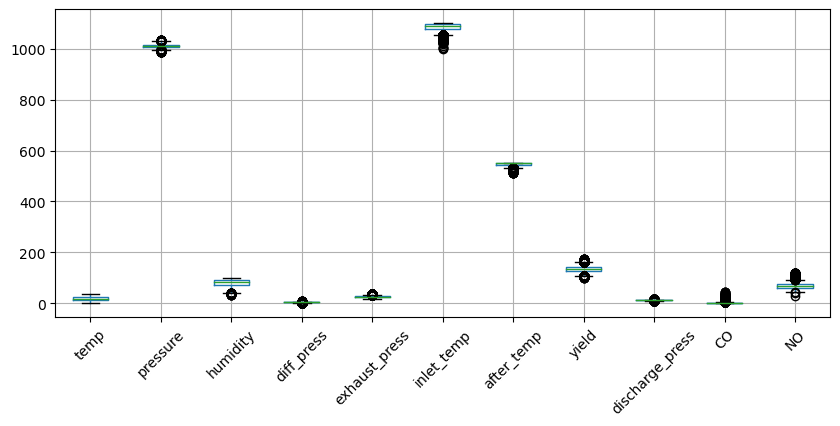

In [6]:
plt.figure(figsize = (10,4))
data.boxplot()
plt.xticks(rotation = 45)
plt.show()

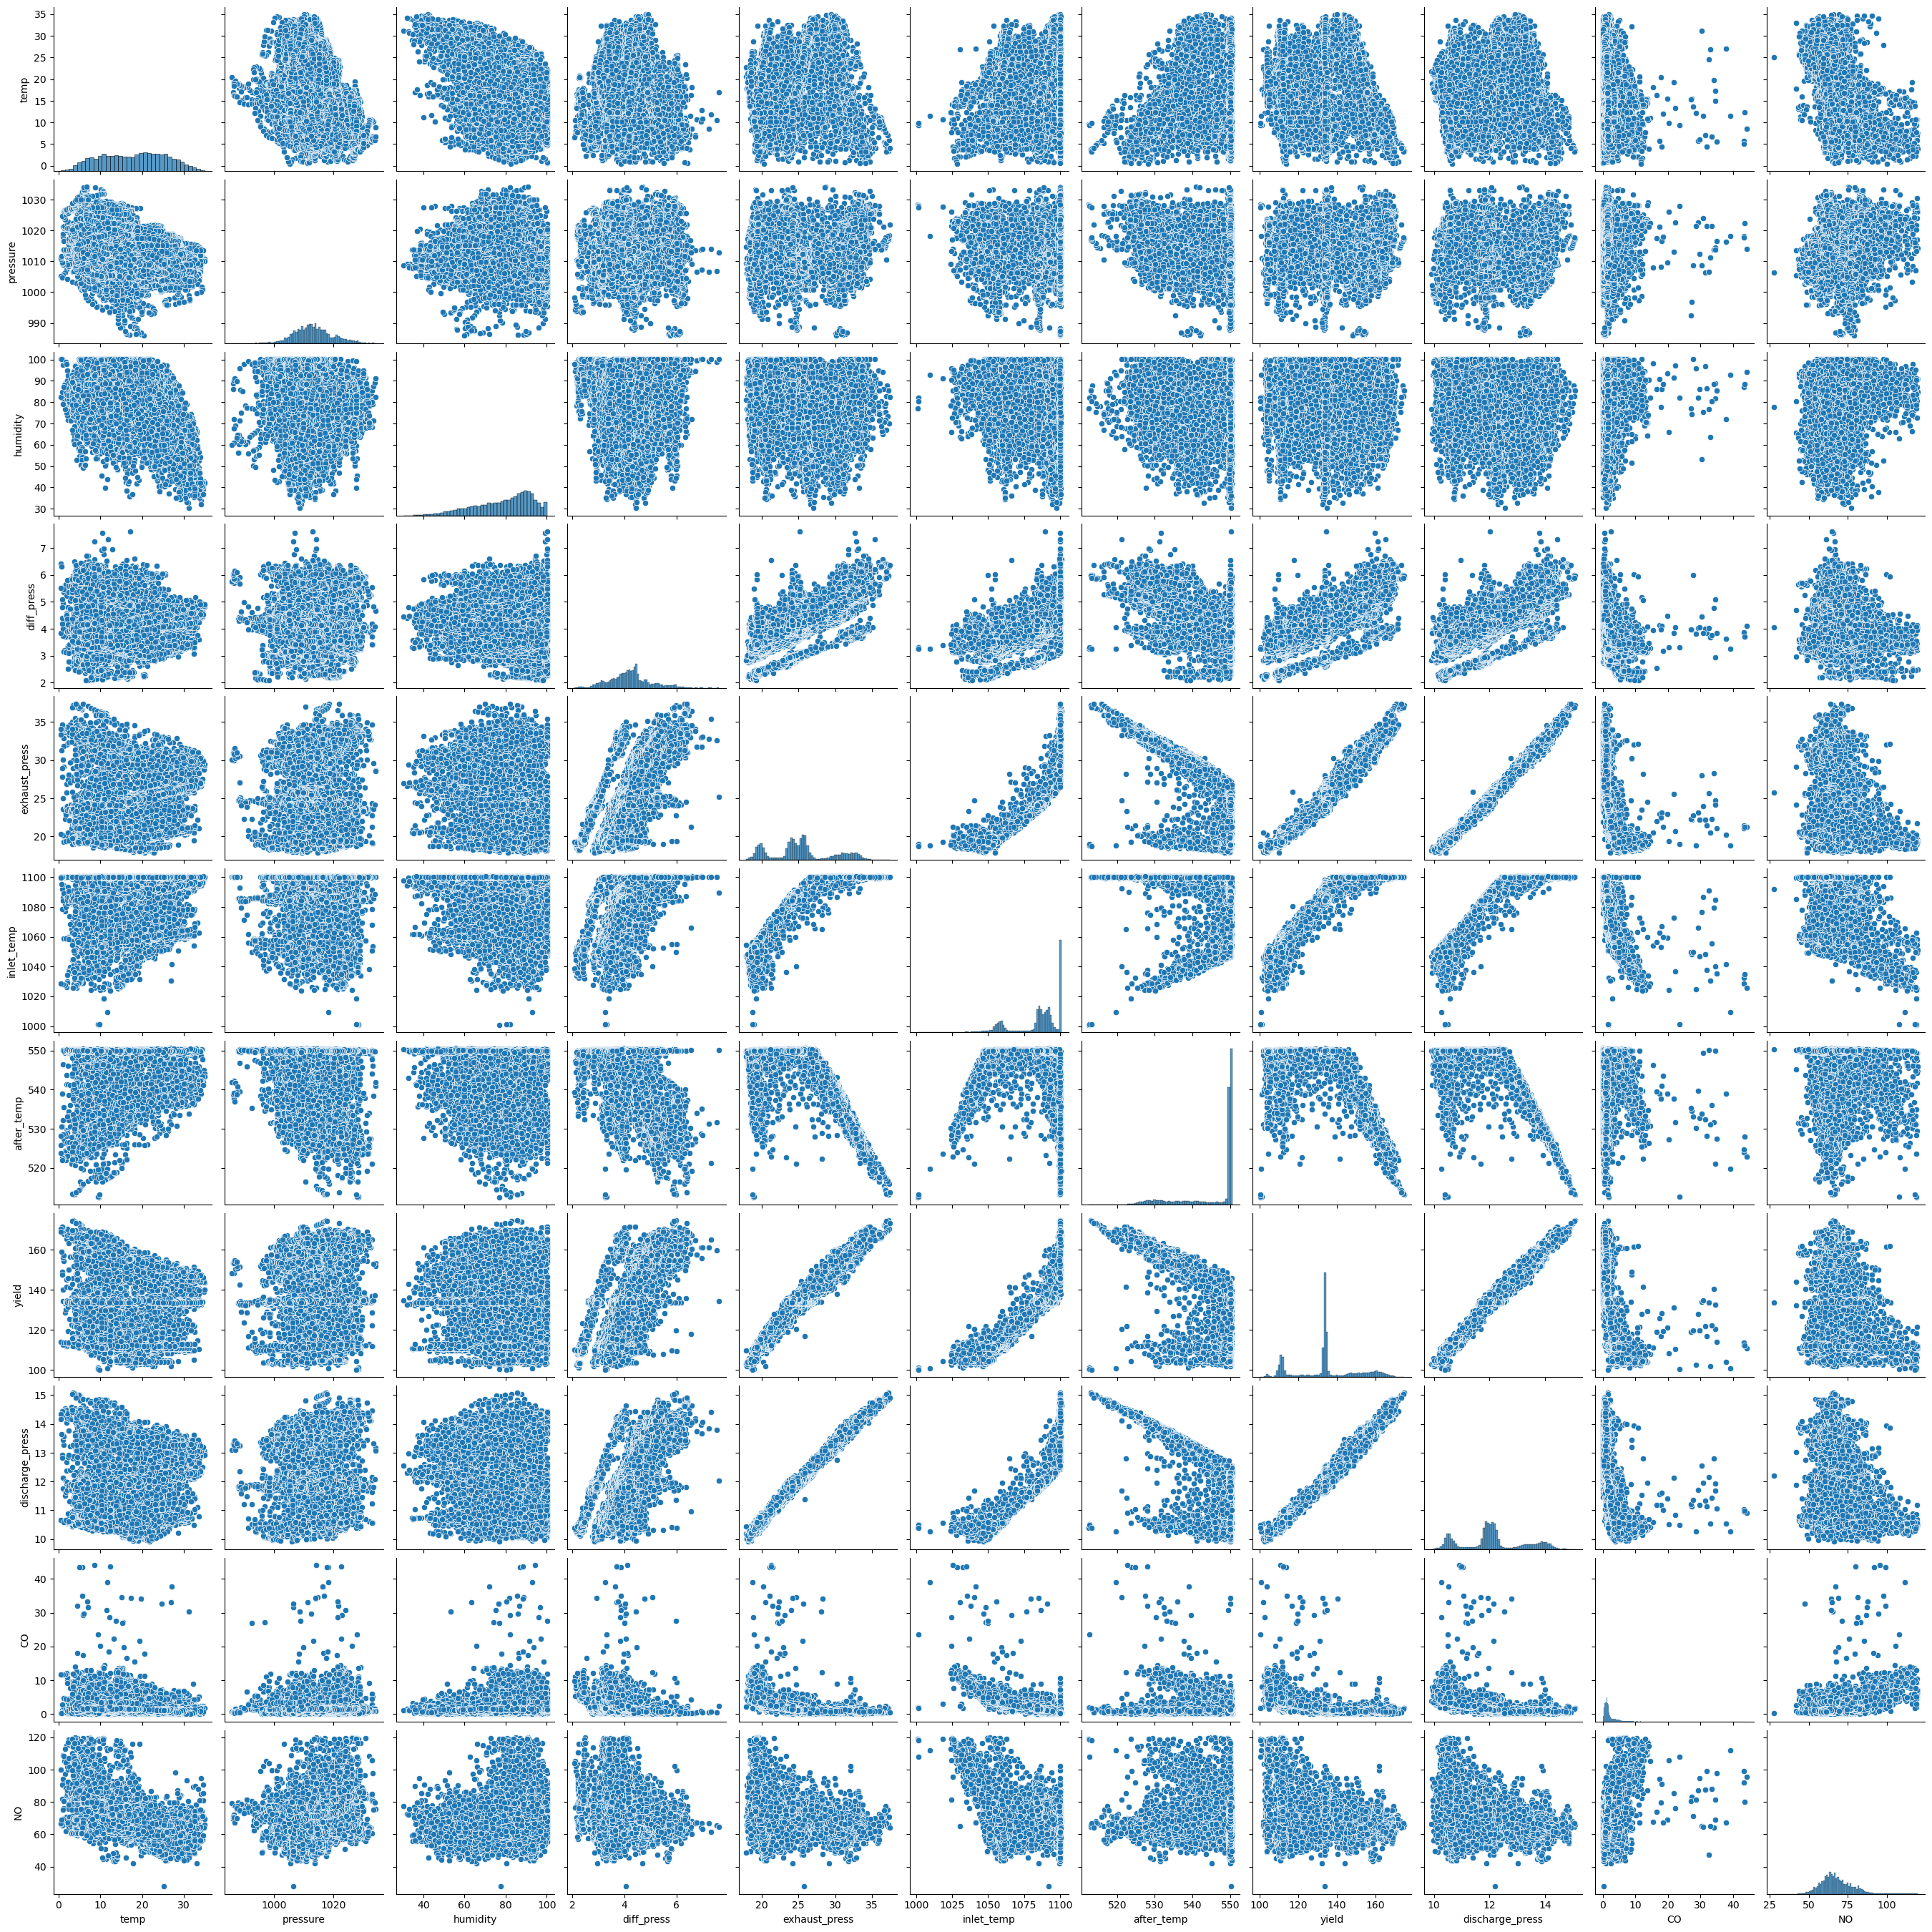

In [7]:
sns.pairplot(data)
plt.show()

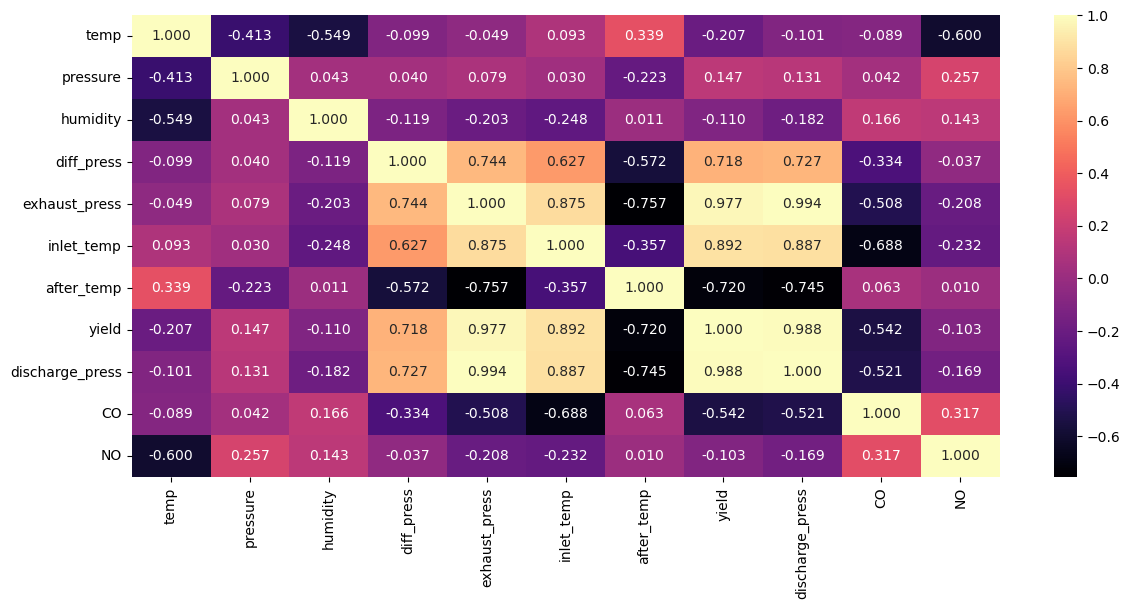

In [8]:
plt.figure(figsize = (14, 6));
sns.heatmap(data.corr(), cmap='magma', annot=True, fmt=".3f")
plt.show()

(1) exhaust_pressure and discharge_pressure show colinearlity.
(2) yield is weakly correlated with the ambient preesure, humidity, nitrogen oxide and ambient temperature

In [9]:
df = data.drop(["temp", "pressure","humidity","NO","exhaust_press","yield"], axis = 1)
Y = data["yield"]
df.head()

diff_press  inlet_temp  after_temp  discharge_press      CO
0      3.5000      1059.2      550.00           10.605  3.1547
1      3.4998      1059.3      550.00           10.598  3.2363
2      3.4824      1059.4      549.87           10.601  3.2012
3      3.4805      1059.6      549.99           10.606  3.1923
4      3.4976      1059.7      549.98           10.612  3.2484

In [10]:
#data standerdization for numerical input variables
scaler = StandardScaler()
df1 = pd.DataFrame(scaler.fit_transform(df))
df1.columns = df.columns
df1.head()

diff_press  inlet_temp  after_temp  discharge_press        CO
0   -0.921232   -1.488376    0.585240        -1.357331  0.532012
1   -0.921495   -1.482325    0.585240        -1.363676  0.568733
2   -0.944385   -1.476275    0.568715        -1.360957  0.552938
3   -0.946884   -1.464173    0.583969        -1.356424  0.548933
4   -0.924389   -1.458123    0.582698        -1.350985  0.574179

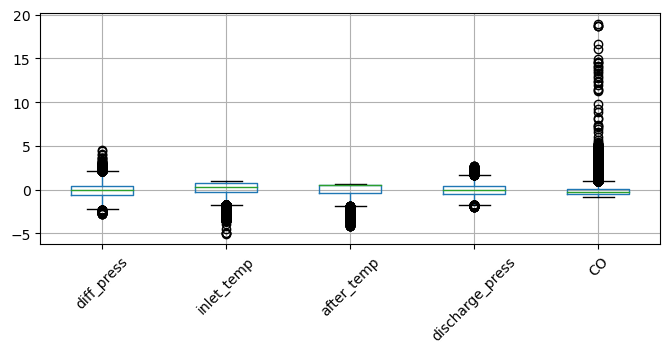

In [11]:
plt.figure(figsize = (8,3))
df1.boxplot()
plt.xticks(rotation = 45)
plt.show()

Skew: 0.14596270190452942
Kurtosis: -0.4870582497451621


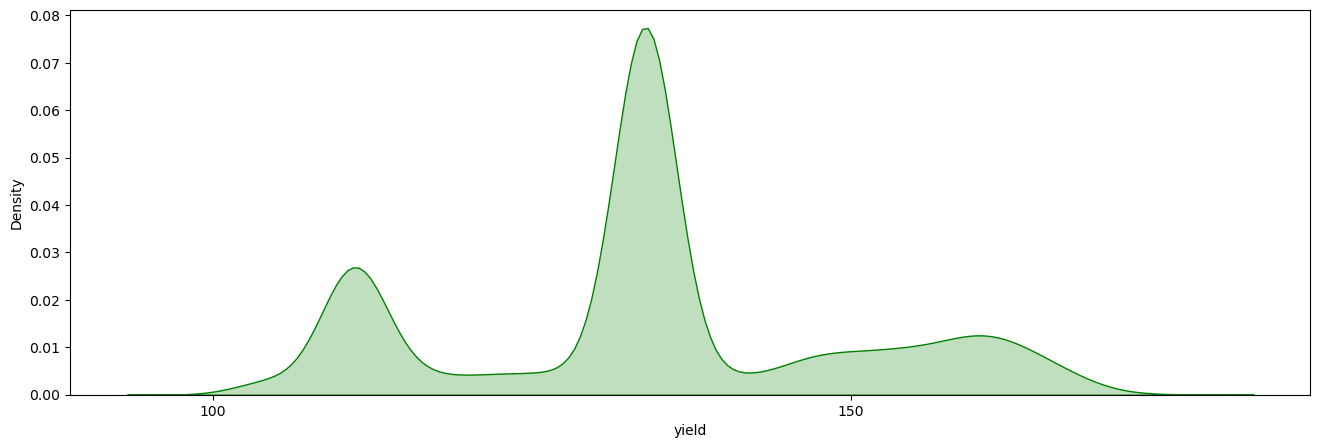

In [12]:
# distribution for the turbine yield
plt.figure(figsize=(16,5))
print("Skew: {}".format(Y.skew()))
print("Kurtosis: {}".format(Y.kurtosis()))
ax = sns.kdeplot(Y,shade=True,color='g')
plt.xticks([i for i in range(100,200,50)])
plt.show()


In [13]:
X = np.array(df1)
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, train_size = 0.75, random_state = 42)
x_train.shape

(11279, 5)

# Model preparation

In [20]:
# Defining the model
from sklearn.model_selection import cross_val_score, KFold
def baseline_model():
    model = Sequential()
    model.add(Dense(8, input_dim=5, activation='relu'))
    model.add(Dense(4, input_dim=8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

#creat an estimator
estimator = KerasRegressor(model=baseline_model, epochs=50, batch_size=10, verbose=0)
results = cross_val_score(estimator, X, Y, cv=KFold())

print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: 0.97 (0.01) MSE


In [22]:
history = estimator.fit(x_train, y_train)
prediction = estimator.predict(x_valid)


In [24]:
from sklearn.metrics import r2_score
# calculate errors
preds = prediction.tolist()
y_true = y_valid.tolist()
errors = list()
for i in range(len(y_true)):
    err = (y_true[i] - preds[i])**2
    errors.append(err)
d = {"yield": y_valid, "prediction":prediction,"error":errors} 
result = pd.DataFrame(data = d)
print("r2:", r2_score(y_true, preds))
result.head()

r2: 0.9880824275978362


yield  prediction     error
13312  134.46  134.323761  0.018561
12627  111.88  113.387711  2.273191
6393   133.72  134.121475  0.161182
4990   133.79  134.584030  0.630484
12462  110.77  110.572952  0.038828

# Conclusion

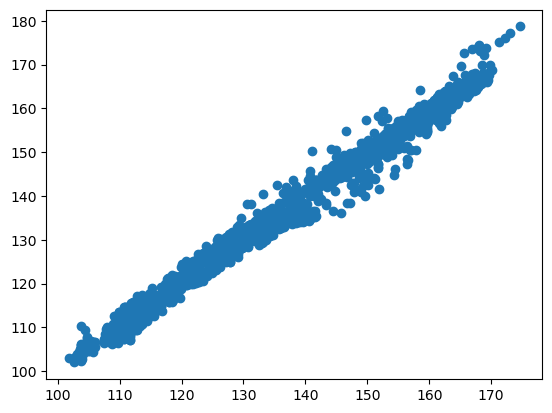

In [25]:
plt.scatter(result["yield"],result["prediction"])
plt.show()

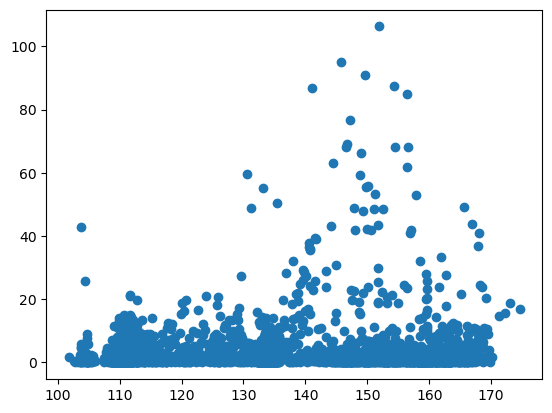

In [26]:
plt.scatter(result["yield"],result["error"])
plt.show()